# Routing

Optical and high speed RF ports have an orientation that routes need to follow to avoid sharp turns that produce reflections.

we have routing functions that route:

- single route between 2 ports
    - `get_route`
    - `get_route_from_steps`
    - `get_route_astar`
- group of routes between 2 groups of ports using a river/bundle/bus router. At the moment it works only when all ports on each group have the same orientation.
    - `get_bundle`
    - `get_bundle_from_steps`


The most useful function is `get_bundle` which supports both single and groups of routes, and can also route with length matching, which ensures that all routes have the same length.

The biggest limitation is that it requires to have all the ports with the same orientation, for that you can use `gf.routing.route_ports_to_side`

In [2]:
from functools import partial
# test
import gdsfactory as gf
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.port import Port

gf.config.rich_output()

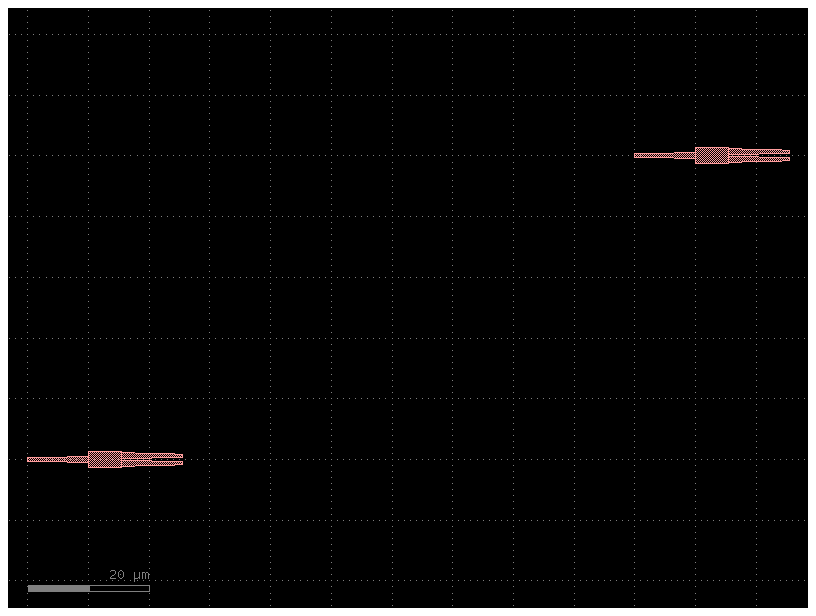

In [3]:
c = gf.Component("sample_no_routes")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
c.plot()

## get_route

`get_route` returns a Manhattan route between 2 ports

In [ ]:
help(gf.routing.get_route)

In [ ]:
c = gf.Component("sample_connect")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o1"], c)
c.add(route.references)
c.plot()

In [ ]:
route

**Problem**: get_route with obstacles

sometimes there are obstacles that connect strip does not see!

In [ ]:
c = gf.Component("sample_problem")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o2"], c)
c.add(route.references)
c.plot()

[ComponentReference (parent Component "rectangle_polygon$1", ports [], origin (135.0, 20.0), rotation 0.0, x_reflection False)]
[array([[125.,  10.],
       [125.,  30.],
       [145.,  30.],
       [145.,  10.]])]
[array([[125.,  10.],
       [125.,  30.],
       [145.,  30.],
       [145.,  10.]])]
here
_generate_route_manhattan_points
[array([[125.,  10.],
       [125.,  30.],
       [145.,  30.],
       [145.,  10.]])]
5
adjusted to 0.4999999999999911
0.4999999999999911 49.999999999999986
8
5
-19.51000000000001 20.01
7
21
good
[[110.    50.  ]
 [  0.5   50.  ]
 [  0.5   20.01]
 [-19.51  20.01]
 [-19.51   0.  ]
 [  0.     0.  ]]
after while loop
[[ 15.5     0.625]
 [125.      0.625]
 [125.     30.615]
 [145.01   30.615]
 [145.01   50.625]
 [125.5    50.625]]
125.00000000000001
routed thru obstacle in x direction
125.00000000000001
routed thru obstacle in x direction
125.5
routed thru obstacle in x direction


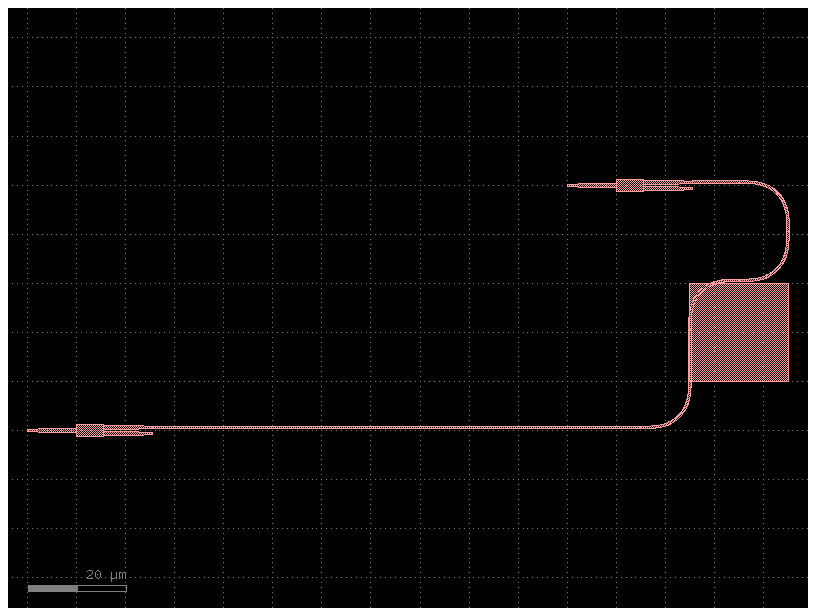

In [4]:
from functools import partial
# test
import gdsfactory as gf
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.port import Port

gf.config.rich_output()

c = gf.Component("sample_problem")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))

rec = gf.Component("rectangle_polygon")
rec.add_polygon(
       [(-10, -10, 10, 10), (-10, 10, 10, -10)], layer=(1, 0)
   )
x = c << rec
x.move((135, 20))

route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o2"], c)
c.add(route.references)
c.plot()

In [ ]:
route

**Solutions:**

- specify the route steps

## get_route_from_steps

`get_route_from_steps` is a manual version of `get_route` where you can define only the new steps `x` or `y` together with increments `dx` or `dy`

In [ ]:
c = gf.Component("get_route_from_steps")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20, "y": 0},
        {"x": 20, "y": 20},
        {"x": 120, "y": 20},
        {"x": 120, "y": 80},
    ],
)
c.add(routes.references)
c.plot()

In [ ]:
c = gf.Component("get_route_from_steps_shorter_syntax")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20},
        {"y": 20},
        {"x": 120},
        {"y": 80},
    ],
)
c.add(routes.references)
c.plot()

## get_bundle

To route groups of ports avoiding waveguide collisions, you should use `get_bundle` instead of `get_route`.

`get_bundle` uses a river/bundle/bus router.

At the moment it works only when each group of ports have the same orientation.


In [ ]:
ys_right = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(ys_right)
ys_left = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-200, ys_left[i]), width=0.5, orientation=0, layer=layer)
    for i in range(N)
]

# you can also mess up the port order and it will sort them by default
left_ports.reverse()

c = gf.Component(name="connect_bundle_v2")
routes = gf.routing.get_bundle(
    left_ports,
    right_ports,
    sort_ports=True,
    start_straight_length=100,
    enforce_port_ordering=False,
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(f"top_{i}", center=(xs_top[i], 0), width=0.5, orientation=270, layer=layer)
    for i in range(N)
]

bot_ports = [
    gf.Port(
        f"bot_{i}",
        center=(xs_bottom[i], -300),
        width=0.5,
        orientation=90,
        layer=layer,
    )
    for i in range(N)
]

c = gf.Component(name="connect_bundle_separation")
routes = gf.routing.get_bundle(
    top_ports, bot_ports, separation=5.0, end_straight_length=100
)
for route in routes:
    c.add(route.references)

c.plot()

`get_bundle` can also route bundles through corners


In [ ]:
@cell
def test_connect_corner(N=6, config="A"):
    d = 10.0
    sep = 5.0
    top_cell = gf.Component()
    layer = (1, 0)

    if config in ["A", "B"]:
        a = 100.0
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(d, a / 2 + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-d, a / 2 + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(d, -a / 2 - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-d, -a / 2 - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(a / 2 + i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-a / 2 - i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(a / 2 + i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-a / 2 - i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    elif config in ["C", "D"]:
        a = N * sep + 2 * d
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(a, d + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-a, d + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(a, -d - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-a, -d - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(d + i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-d - i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(d + i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-d - i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    if config in ["A", "C"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports1, ports2, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    elif config in ["B", "D"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports2, ports1, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    return top_cell


c = test_connect_corner(config="A")
c.plot()

In [ ]:
c = test_connect_corner(config="C")
c.plot()

In [ ]:
@cell
def test_connect_bundle_udirect(dy=200, orientation=270, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35, 24, 0] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [70 + i * pitch for i in range(N)]

    if axis == "X":
        ports1 = [
            Port(
                f"top_{i}",
                center=(0, xs1[i]),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(
                f"top_{i}",
                center=(xs1[i], 0),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

    top_cell = Component()
    routes = gf.routing.get_bundle(
        ports1, ports2, radius=10.0, enforce_port_ordering=False
    )
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_udirect()
c.plot()

In [ ]:
@cell
def test_connect_bundle_u_indirect(dy=-200, orientation=180, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [50 + i * pitch for i in range(N)]

    a1 = orientation
    a2 = a1 + 180

    if axis == "X":
        ports1 = [
            Port(f"top_{i}", center=(0, xs1[i]), width=0.5, orientation=a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=a2,
                layer=layer,
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=a2,
                layer=layer,
            )
            for i in range(N)
        ]

    top_cell = Component()
    routes = gf.routing.get_bundle(
        ports1,
        ports2,
        bend=gf.components.bend_euler,
        radius=5,
        enforce_port_ordering=False,
    )
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_u_indirect(orientation=0)
c.plot()

In [ ]:
@gf.cell
def test_north_to_south(layer=(1, 0)):
    dy = 200.0
    xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

    pitch = 10.0
    N = len(xs1)
    xs2 = [-20 + i * pitch for i in range(N // 2)]
    xs2 += [400 + i * pitch for i in range(N // 2)]

    a1 = 90
    a2 = a1 + 180

    ports1 = [
        gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
        for i in range(N)
    ]

    ports2 = [
        gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
        for i in range(N)
    ]

    c = gf.Component()
    routes = gf.routing.get_bundle(ports1, ports2, auto_widen=False)
    for route in routes:
        c.add(route.references)

    return c


c = test_north_to_south()
c.plot()

In [ ]:
@gf.cell
def demo_connect_bundle():
    """combines all the connect_bundle tests"""
    y = 400.0
    x = 500
    y0 = 900
    dy = 200.0
    c = gf.Component()
    for j, s in enumerate([-1, 1]):
        for i, orientation in enumerate([0, 90, 180, 270]):
            ci = test_connect_bundle_u_indirect(dy=s * dy, orientation=orientation)
            ref = ci.ref(position=(i * x, j * y))
            c.add(ref)

            ci = test_connect_bundle_udirect(dy=s * dy, orientation=orientation)
            ref = ci.ref(position=(i * x, j * y + y0))
            c.add(ref)

    for i, config in enumerate(["A", "B", "C", "D"]):
        ci = test_connect_corner(config=config)
        ref = ci.ref(position=(i * x, 1700))
        c.add(ref)

    return c


c = demo_connect_bundle()
c.plot()

In [ ]:
c = gf.Component("route_bend_5um")
c1 = c << gf.components.mmi2x2()
c2 = c << gf.components.mmi2x2()

c2.move((100, 50))
routes = gf.routing.get_bundle(
    [c1.ports["o4"], c1.ports["o3"]], [c2.ports["o1"], c2.ports["o2"]], radius=5
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("electrical")
c1 = c << gf.components.pad()
c2 = c << gf.components.pad()
c2.move((200, 100))
routes = gf.routing.get_bundle(
    [c1.ports["e3"]], [c2.ports["e1"]], cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

**Problem**

Sometimes 90 degrees routes do not have enough space for a Manhattan route

In [ ]:
c = gf.Component("route_fail_1")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
c.plot()

In [ ]:
c = gf.Component("route_fail_v2")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    auto_widen=False,
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("route_fail_v3")
pitch = 2.0
ys_left = [0, 10, 20]
N = len(ys_left)
ys_right = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-50, ys_left[i]), width=0.5, orientation=0, layer=layer)
    for i in range(N)
]
left_ports.reverse()
routes = gf.routing.get_bundle(right_ports, left_ports, radius=5)

for route in routes:
    c.add(route.references)
c.plot()

**Solution**

Add Sbend routes using `get_bundle_sbend`

In [ ]:
c = gf.Component("route_solution_1_get_bundle_sbend")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle_sbend(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    enforce_port_ordering=False,
)
for route in routes:
    c.add(route.references)
c.plot()

You can also `get_bundle` adding `with_sbend=True`

In [ ]:
c = gf.Component("route_solution_2_get_bundle")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    with_sbend=True,
    enforce_port_ordering=False,
)
for route in routes:
    c.add(route.references)
c.plot()

### get_bundle with path_length_match

Sometimes you need to route two groups of ports keeping the same route lengths.

In [ ]:
c = gf.Component("path_length_match_routing")
dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle(
    ports1,
    ports2,
    path_length_match_loops=1,
    path_length_match_modify_segment_i=-2,
    end_straight_length=800,
)

for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

### path_length_match with extra length

You can also add some extra length to all the routes

In [ ]:
c = gf.Component("get_bundle_path_length_match_extra_length")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle(
    ports1,
    ports2,
    path_length_match_extra_length=44,
    path_length_match_loops=2,
    end_straight_length=800,
)
for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

### path length match with extra loops

You can also increase the number of loops

In [ ]:
c = gf.Component("get_route_path_length_match_nb_loops")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 200.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle(
    ports1,
    ports2,
    path_length_match_loops=2,
    auto_widen=False,
    end_straight_length=800,
    separation=30,
)
for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

Sometimes you need to modify `separation` to ensure waveguides don't overlap.

In [ ]:
c = gf.Component("problem_path_length_match")
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=30,  # not enough
    radius=5,
    path_length_match_loops=1,
    enforce_port_ordering=False,
)

for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("solution_path_length_match")
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=80,  # increased
    path_length_match_loops=1,
    radius=5,
    enforce_port_ordering=False,
)

for route in routes:
    c.add(route.references)
c.plot()

### get bundle with different orientation ports

When trying to route ports with different orientations you need to bring them to a common `x` or `y`


1. Use `route_ports_to_side` to bring all the ports to a common angle orientation and x or y.
2. Use `get_bundle` to connect to the other group of ports.

In [ ]:
from gdsfactory.samples.big_device import big_device

c = gf.Component("sample_route")
c1 = c << big_device()
c2 = c << gf.components.grating_coupler_array(n=len(c1.ports), rotation=-90)

routes, ports = gf.routing.route_ports_to_side(c1.ports, side="south")
for route in routes:
    c.add(route.references)

c2.ymin = -600
c2.x = 0

routes = gf.routing.get_bundle(ports, c2.ports)
for route in routes:
    c.add(route.references)

c.plot()

## get_bundle_from_steps

This is a manual version of `get_bundle` that is more convenient than defining the waypoints.

In [ ]:
c = gf.Component("get_route_from_steps_sample")
w = gf.components.array(
    partial(gf.components.straight, layer=(2, 0)),
    rows=3,
    columns=1,
    spacing=(0, 50),
)

left = c << w
right = c << w
right.move((200, 100))
p1 = left.get_ports_list(orientation=0)
p2 = right.get_ports_list(orientation=180)

routes = gf.routing.get_bundle_from_steps(
    p1,
    p2,
    steps=[{"x": 150}],
)

for route in routes:
    c.add(route.references)

c.plot()